# ESTUDIO DE LA CORRELACIÓN ENTRE ARG Y MGE
El objetivo de este script es encontrar la correlación entre ARG y MGE a distintos niveles (general, diferenciando por sitio y, si eso, por tipo de muestra) y, en última instancia, representarla. 

Para ello, necesito toda la información, no sólo la presencia única de una amplificación: me interesa también considerar los casos en los que no haya amplificado nada (en el análisis de expresión diferencial optamos por no considerar los no amplificados de ninguna manera, aquí es inevitable). Por tanto, trabajaré con "ab_data_all_fixed.csv". Ahora bien, no tiene sentido buscar correlaciones entre genes que no hayan amplificado.

Por último, me dejo de chiquilladas: ARG vs MGE, y sólamente estadísticos (sólamente correlación de Spearman).

In [1]:
import pandas as pd
from scipy import stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np

In [2]:
all_data = pd.read_csv("../data/resistome_data/clean_data/ab_data_all_fixed.csv", index_col = 0)

all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3

all_data = all_data[["Assay", "antib", "sample", "place", "type_g", "or_seq", "rel_ab"]]
all_data

,Assay,antib,sample,place,type_g,or_seq,rel_ab
0,aacC2,Aminoglycoside,25.0,ardley,plastic,arg,0.000222
1,aacA/aphD,Aminoglycoside,25.0,ardley,plastic,arg,0.000046
2,aac(6')-II,Aminoglycoside,25.0,ardley,plastic,arg,0.006918
3,aphA3,Aminoglycoside,25.0,ardley,plastic,arg,NaN
4,sat4,Aminoglycoside,25.0,ardley,plastic,arg,NaN
...,...,...,...,...,...,...,...
10309,dfrAB4,Trimethoprim,14.0,ion,control,arg,NaN
10310,dfrC,Trimethoprim,14.0,ion,control,arg,NaN
10311,dfrG,Trimethoprim,14.0,ion,control,arg,NaN
10312,dfrK,Trimethoprim,14.0,ion,control,arg,NaN


Primer paso, quedarme con aquellas secuencias que hayan amplificado aunque sea sólo en 1 muestra de todas las que aparecen. Véase, si aparece, me lo quedo.


In [4]:
# función muy tonta con el objetivo de tomar un df con valores de la variable col1, repetida n veces, 
# que pueden estar presentes (>0) o ausentes (=0). Busca quedarse con aquellos con mínimo un positivo
# en col1 y filtrar el df original para que esto sea cierto
def get_hits(df, col1_name, col2_name):
    hits = df.groupby(by = col1_name).sum() #sólo serán >0 aquellos que amplifiquen
    hits = list(hits[(hits[col2_name] != 0)].index) #coge los positivos, saca la lista de ellos (= el índice)
    df = df.loc[(df[col1_name].isin(hits))]
    return df

In [5]:
def get_n_hits(df, groupby_colname, hits_colname, min_hits):
    """
    La intención de esta función tontorrona es tomar un df con datos de amplificaciones tal cual y devolver un df de amplificaciones filtrado,
    en el cual permanezcan sólo aquellos datos que tengan un nº suficiente de datos diferenciados para determinada variable categórica. En este caso,
    aquellas secuencias (variable categórica) que tengan un número mínimo de amplificaciones (teniendo en cuenta que la no amplificación = NaN o 0, tener
    un nº mínimo de datos diferentes implica tener mínimo una cantidad de secuencias amplificando)
        - df: el DataFrame de partida
        - groupby_colname: el nombre de la columna tipo variable categórica que nos interesa estudiar
        - hits_colname: el nombre de la columna en la que queremos tener el nº mínimo de resultados diferenciados
        - min_hits: el nº mínimo de resultados diferenciados
    """
    group_data = df.groupby(groupby_colname)
    enough_hits = []
    for name, group in group_data:
        if len(group[hits_colname].unique()) > (min_hits + 1): enough_hits.append(name) # Ese +1 es para considerar el valor de ausencia, sea NaN o 0. 
    df = df.loc[(df[groupby_colname].isin(enough_hits))]
    return df

In [6]:
print(all_data.shape[0]) #para chequear si funciona o no
work_data = get_n_hits(df = all_data, 
                       groupby_colname = "Assay", 
                       hits_colname = "rel_ab", 
                       min_hits = 3) 
print(work_data.shape[0]) #para chequear si funciona o no

del all_data
work_data.reset_index(inplace = True, drop = True) #si el index está descolocado da problemas
len(work_data["Assay"].unique())

10287
8370


310

In [7]:
work_data = work_data.fillna(value = 0)
work_data["rel_ab"] = work_data["rel_ab"] + 1 
work_data["n_log2"] = np.log2(work_data["rel_ab"])
work_data.head()

,Assay,antib,sample,place,type_g,or_seq,rel_ab,n_log2
0,aacC2,Aminoglycoside,25.0,ardley,plastic,arg,1.000222,0.000320
1,aac(6')-II,Aminoglycoside,25.0,ardley,plastic,arg,1.006918,0.009947
2,aphA3,Aminoglycoside,25.0,ardley,plastic,arg,1.000000,0.000000
3,aac(6')-Ib,Aminoglycoside,25.0,ardley,plastic,arg,1.079250,0.110029
4,aadA2a,Aminoglycoside,25.0,ardley,plastic,arg,1.015205,0.021772


Y ahora defino dos funciones para a) calcular el valor de la correlación de spearman y b) ordenar el resultado para formar una pivot table

In [8]:
def spearman_finder (x, y, merge_col_name = "sample", groupby_name = "Assay", test_col = "n_log2",
                     p_val = 0.05, threshold = 0,
                     min_n_global = 3, min_n_x = 1, min_n_y = 1):
    """
    Función para calcular automáticamente la correlación de Spearman entre dos grupos de una variable en un mismo df. También incluye funciones para definir el nº de mínimo de datos
    con los que llevar a cabo el cálculo y el nivel de significancia de los mismos. Véase, puedo especificar cuántos datos distintos son necesarios como MÍNIMO antes de calcular la
    correlación, y el p-valor frente al que guardar los resultados. EL resultado final es un diccionario, con una dupla para la llave con los groupby_col en cuestión y su valor, el nivel de correlación.
    
    x: dataframe 1. Debe provenir de un df original en el que se corresponda con TODOS los datos iguales a cierto valor descriptivo en una variable descriptiva del df original
    y: dataframe 2. Ídem, en este caso los datos que no tengan dicho valor
    merge_col_name: nombre la columna del df original en el que queden agrupados los datos por réplica biológica.
    groupby_name: nombre de la columna del df original en la cual se recojan los datos de variable descriptiva que se quieren correlacionar. Véase, se corresponderán con los valores en los ejes x e y 
    test_col: nombre de la columna del df original que recoja los datos de una variable cuantitativa. Los valores en sí de x y de y
    p_val: valor del p-valor a partir del cual el resultado se considerará significativo
    threshold: valor de correlación mínimo a partir del cual el resultado se considerará significativo
    min_n_global: cantidad de datos DIFERENTES A 0 que debe tener test_col para que el resultado se considere válido, BIEN PARA X, BIEN PARA Y.
    min_n_x: cantidad de datos DIFERENTES A 0 que debe tener test_col en x para que el resultado se considere válido
    min_n_y: cantidad de datos DIFERENTES A 0 que debe tener test_col en y para que el resultado se considere válido
    """
    
    
    # Lleva a cabo el merge original, el emparejamiento
    merged_df = pd.merge(x, y, on = merge_col_name)
    
    # Genera los nuevos nombres de variable
    group_x = groupby_name + "_x"
    group_y = groupby_name + "_y"
    test_x = test_col + "_x"
    test_y = test_col + "_y"
    
    grouped_merge = merged_df.groupby([group_x, group_y]) #y empareja
    
    corr_dict = {} 
    
    for name, group in grouped_merge: #siempre sumo 1 para considerar el = 0
        if (len(group[test_x].unique()) > (min_n_global + 1)) or (len(group[test_y].unique()) > (min_n_global + 1)) or ((len(group[test_x].unique()) > (min_n_x + 1)) and (len(group[test_x].unique()) > (min_n_y + 1))):
            corr_res = stat.spearmanr(group[test_x], group[test_y], nan_policy = "omit")
            if (abs(corr_res[0]) >= threshold) and (corr_res[1] < p_val): corr_dict[name] = corr_res #ojo, el valor absoluto
    return corr_dict

In [9]:
def dict_pivotizer(results_dict, copy = False,
                  id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                  id1_fam = "MGE_family", id2_fam = "ARG_family"):
    """
    Esta función lo que hace es automatizar un montón de pasos que sigo para pasar de los diccionarios con resultados de correlación originales
    generados por las distintas funciones a la pivot table final que seaborn sabe interpretar. Esta hardcodeado a lo bestia y probablemente
    no pueda reusarlo en otros contextos, pero por cuestiones de limpieza es mejor que declare esto una vez y me olvide de aquí en adelante
    
    - results_dict: el diccionario que contiene los resultados que se quieren representar
    - copy: por si se quisiera sacar una copia de los resultados y así evitar recalcular
    - id1_name: nombre de la primera variable correlacionada, LA QUE SE REPRESENTA EN HORIZONTAL, LOS NOMBRES DE LAS COLUMNAS
    - id2_name: nombre de la segunda variable correlacionada, LA QUE SE REPRESENTA EN VERTICAL, LOS NOMBRES DE LAS FILAS
    - id1_fam: nombre de la agrupación de la variable 1. Sirve para ordenar la pivot final agrupando datos
    - id2_fam: nombre de la agrupación de la variable 2. Sirve para ordenar la pivot final agrupando datos
    - val_name: nombre que de los valores que se están representando
    """
    #coge el diccionario original y lo pasa a df
    corr_df = pd.DataFrame(results_dict)
    corr_df = corr_df.T
    corr_df.index.set_names([id1_name, id2_name], inplace = True) #en ese orden salen los resultados
    corr_df.rename(columns = {0: val_name}, inplace = True)
    corr_df.reset_index(inplace = True)
    if copy == True: #en aquellos casos que me interesa generar una copia en archivo del csv, este es el mejor momento
        print("Copying! REMEMBER TO CHANGE THE NAME!!")
        corr_df.to_csv("../data/clean_data/quick_copy.csv")
    
    # Este paso de aquí sirve para conseguir la información de familias de ARG/MGE 
    fam_fix = work_data[["Assay", "antib"]]
    fam_fix = fam_fix.drop_duplicates(subset = ["Assay"]) 
    fam_fix.rename(columns = {"Assay": id2_name}, inplace = True) #llama "ARG" A TODO, INCLUYENDO MGE
    #junta los resultados con su familia de antibiótico
    corr_df = pd.merge(left = corr_df, right = fam_fix, #OJO, sólo se va a quedar con los ARG, ningún MGE queda asignado
                       on = id2_name, how = "inner")
    corr_df.rename(columns = {"antib": id2_fam}, inplace = True) #esto le pone un nombre lógico a la columna
    # ugly hack que asigna los MGE sin duplicar nada
    fam_fix.rename(columns = {"ARG": id1_name}, inplace = True)
    corr_df = pd.merge(left = corr_df, right = fam_fix,
                   on = id1_name, how = "inner")
    corr_df.rename(columns = {"antib": id1_fam}, inplace = True)
    #genera la pivot final. Ojo que está multiindexada
    final_pivot = pd.pivot_table(data = corr_df,
                                 values = val_name,
                                 columns = [id1_fam, id1_name],
                                 index = [id2_fam, id2_name])
    return final_pivot

In [10]:
corr_data = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "plastic")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "plastic")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "n_log2",
                            threshold = 0.75,
                            p_val = 0.001,
                            min_n_global = 4,
                            min_n_x = 2,
                            min_n_y = 2
                           )
general_plastic = dict_pivotizer(corr_data, copy = False,
                               id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                               id1_fam = "MGE_family", id2_fam = "ARG_family")
general_plastic = general_plastic.fillna(0)

In [11]:
general_plastic.shape
#general_plastic.min()

(242, 58)

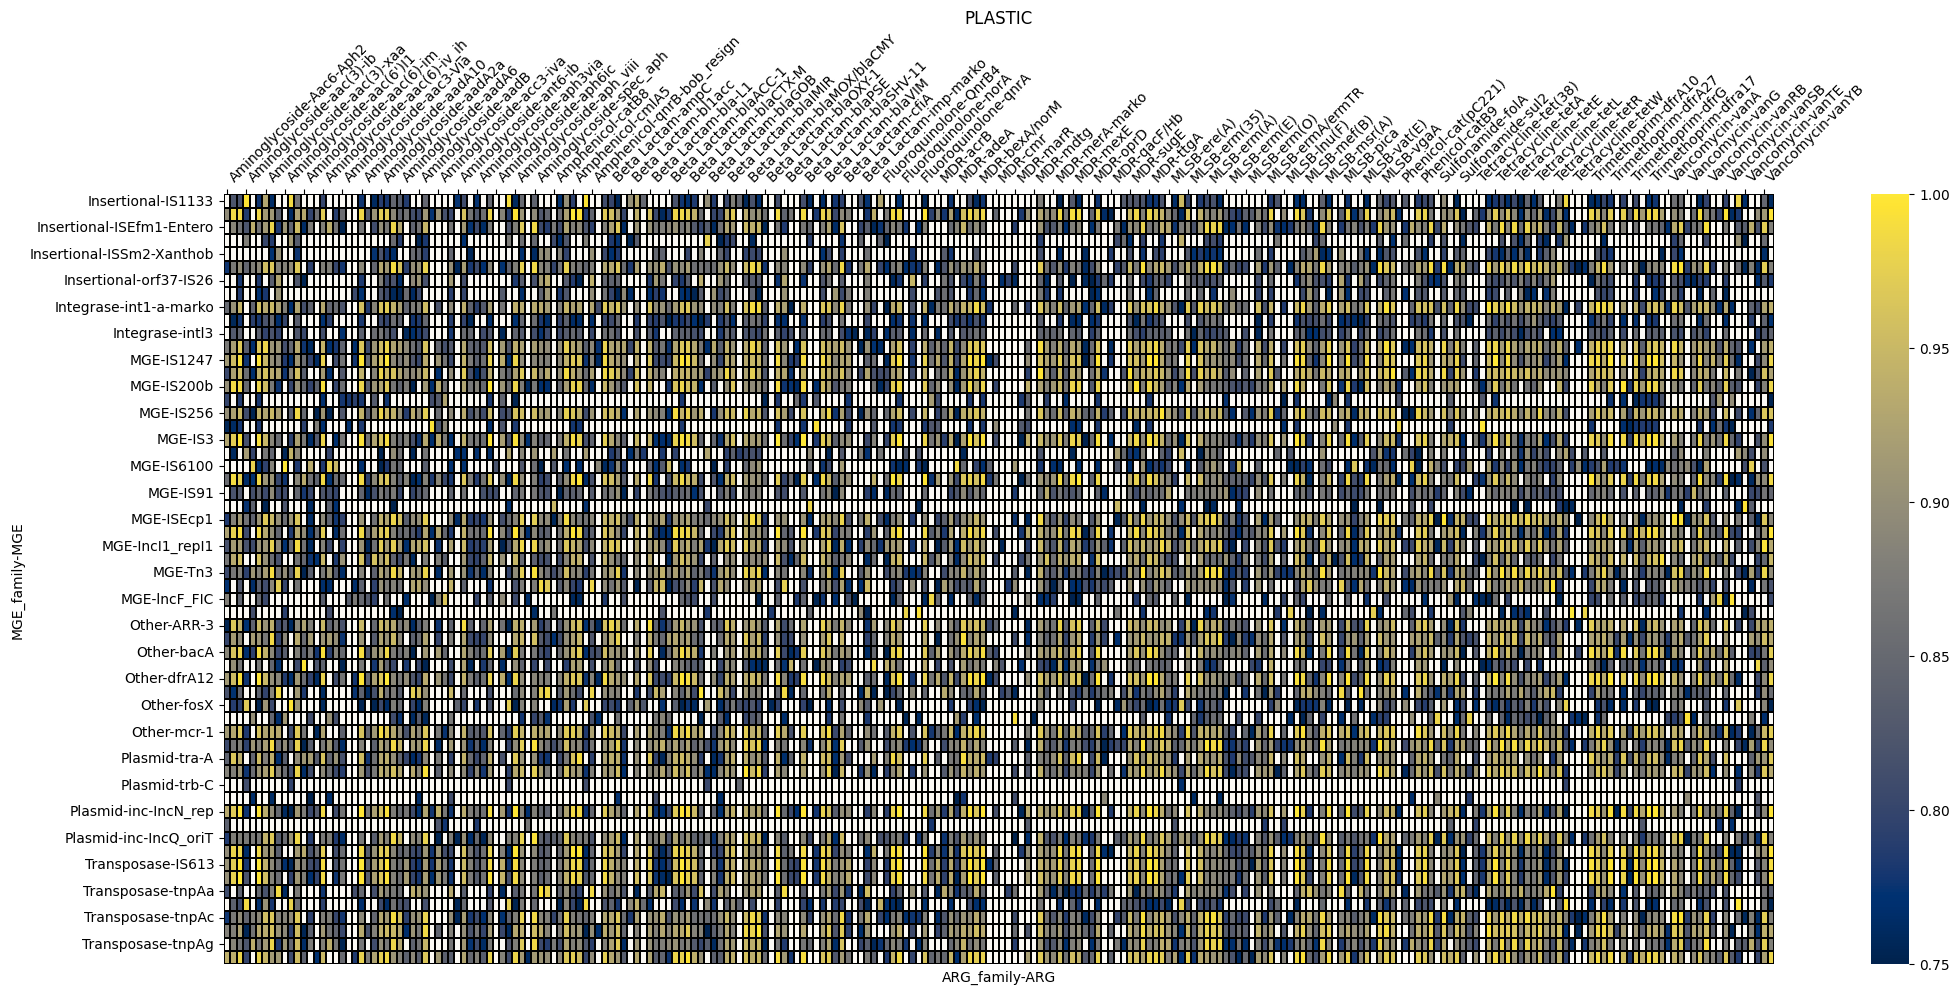

In [13]:
fig, ax = plt.subplots(figsize=(25,10))
red_cmap = mpl.colormaps["cividis"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(abs(general_plastic.T), 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.75,
                   linecolor = "black",
                   linewidths = 0.003, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("PLASTIC")
ax.xaxis.tick_top()

El df de la correlación en todas las muestras probablemente sea el de mayor tamaño de todos los que se generen, asi que para poder contrastar la información de la manera más sencilla voy a hacer que comparta esqueleto con el resto.

In [14]:
empty_pivot = general_plastic.copy(deep = True)

for col in empty_pivot.columns:
    empty_pivot[col].values[:] = 0
empty_pivot.tail()

MGE_family       Insertional                                            \
MGE                   IS1133 ISAba3-Acineto ISEfm1-Entero ISPps1-pseud   
ARG_family ARG                                                           
Vancomycin vanTE         0.0            0.0           0.0          0.0   
           vanTG         0.0            0.0           0.0          0.0   
           vanWB         0.0            0.0           0.0          0.0   
           vanYB         0.0            0.0           0.0          0.0   
           vanYD         0.0            0.0           0.0          0.0   

MGE_family                                                   Integrase  \
MGE              ISSm2-Xanthob  TN5 orf37-IS26 orf39-IS26 int1-a-marko   
ARG_family ARG                                                           
Vancomycin vanTE           0.0  0.0        0.0        0.0          0.0   
           vanTG           0.0  0.0        0.0        0.0          0.0   
           vanWB           0.0  0.0        0.0        0.0          0.0   
           vanYB           0.0  0.0        0.0        0.0          0.0   
           vanYD           0.0  0.0        0.0        0.0          0.0   

MGE_family                           ... Plasmid-inc            Transposase  \
MGE              intI1F165_clinical  ...   IncQ_oriT IncW_trwAB       IS613   
ARG_family ARG                       ...                                      
Vancomycin vanTE                0.0  ...         0.0        0.0         0.0   
           vanTG                0.0  ...         0.0        0.0         0.0   
           vanWB                0.0  ...         0.0        0.0         0.0   
           vanYB                0.0  ...         0.0        0.0         0.0   
           vanYD                0.0  ...         0.0        0.0         0.0   

MGE_family                                                 
MGE              Tp614 tnpAa tnpAb tnpAc tnpAf tnpAg trfa  
ARG_family ARG                                             
Vancomycin vanTE   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
           vanTG   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
           vanWB   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
           vanYB   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
           vanYD   0.0   0.0   0.0   0.0   0.0   0.0  0.0  

[5 rows x 58 columns]

Y ya tengo el esqueleto en el que poder encajar el resto de datos

In [15]:
corr_data = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "control")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "control")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "n_log2",
                            threshold = 0.75,
                            p_val = 0.001,
                            min_n_global = 4,
                            min_n_x = 2,
                            min_n_y = 2
                           )
general_control = dict_pivotizer(corr_data, copy = False,
                               id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                               id1_fam = "MGE_family", id2_fam = "ARG_family")

print(general_control.shape)
general_control = empty_pivot + general_control
print(general_control.shape)
general_control = general_control.fillna(0)

/home/juanma/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(121, 17)
(250, 58)


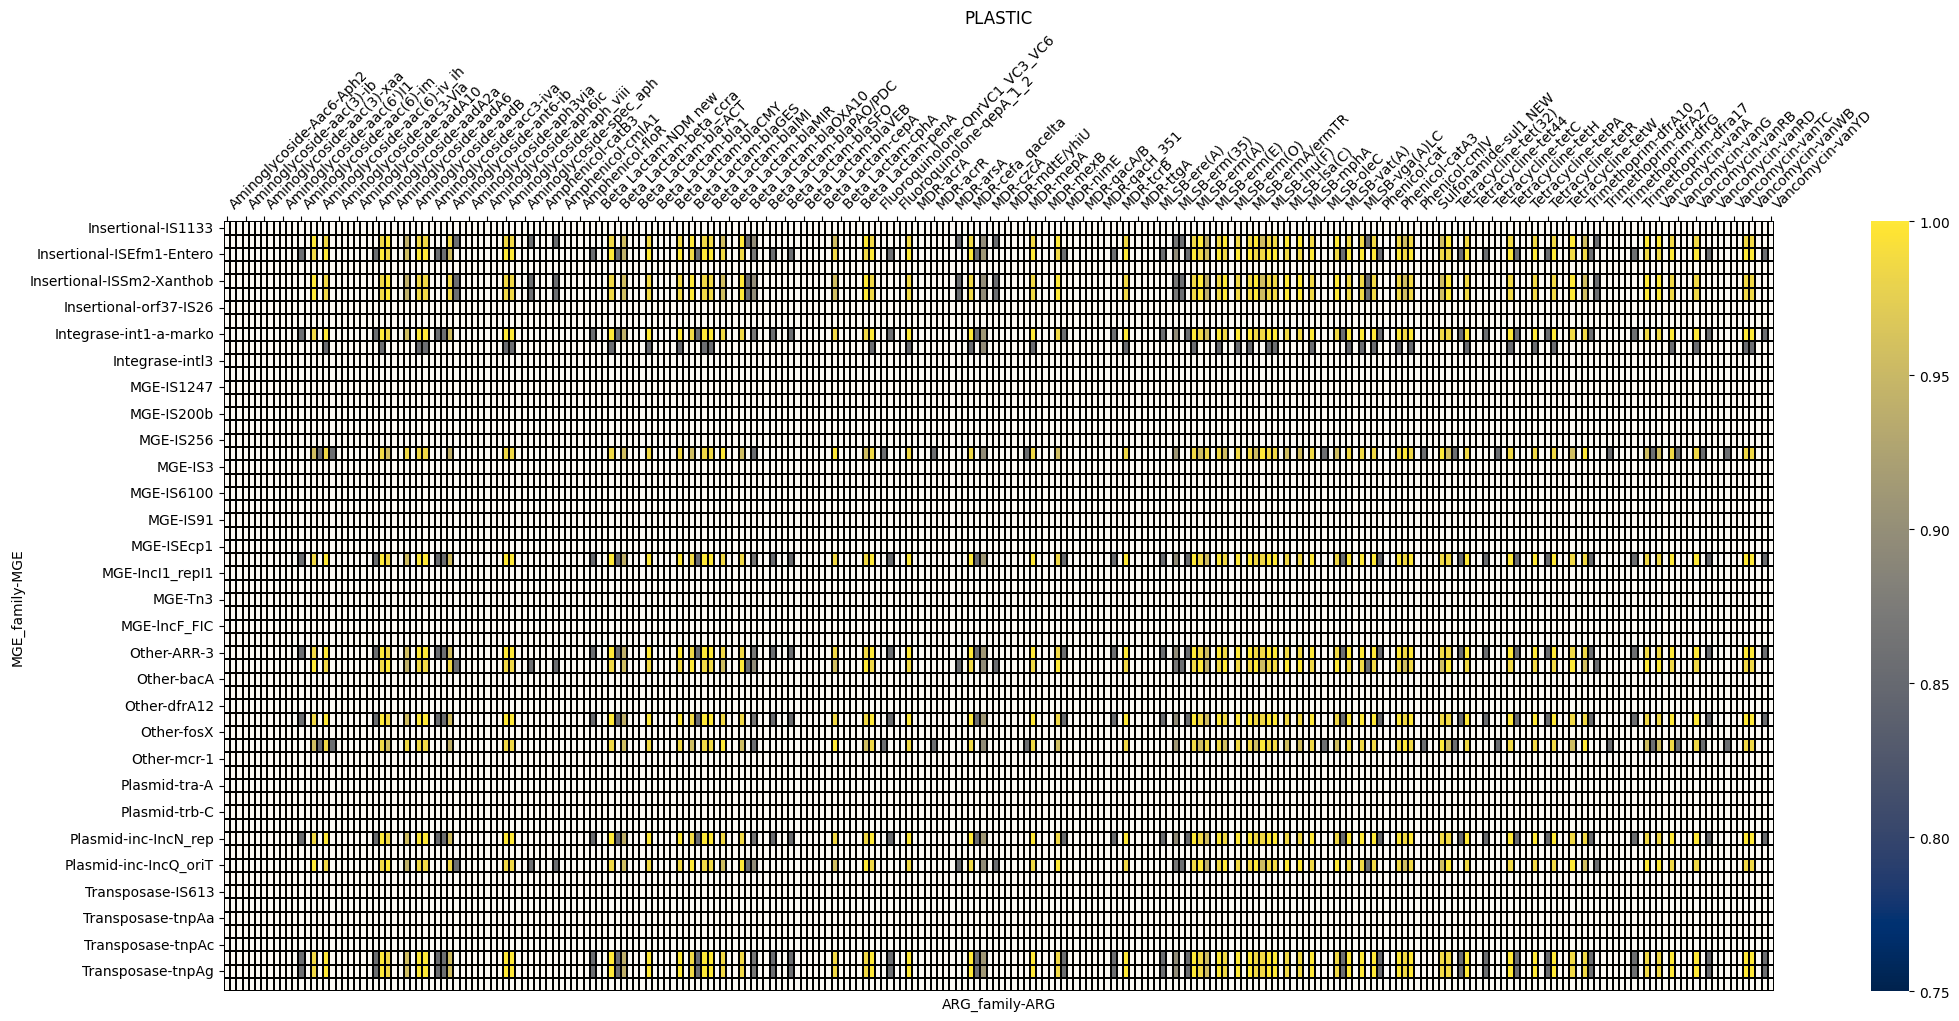

In [16]:
fig, ax = plt.subplots(figsize=(25,10))
red_cmap = mpl.colormaps["cividis"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(abs(general_control.T), 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.75,
                   linecolor = "black",
                   linewidths = 0.003, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("PLASTIC")
ax.xaxis.tick_top()

Al no haber valores negativos en ninguno, nos podemos permitir restar ambos dfs para tener una comparativa visual

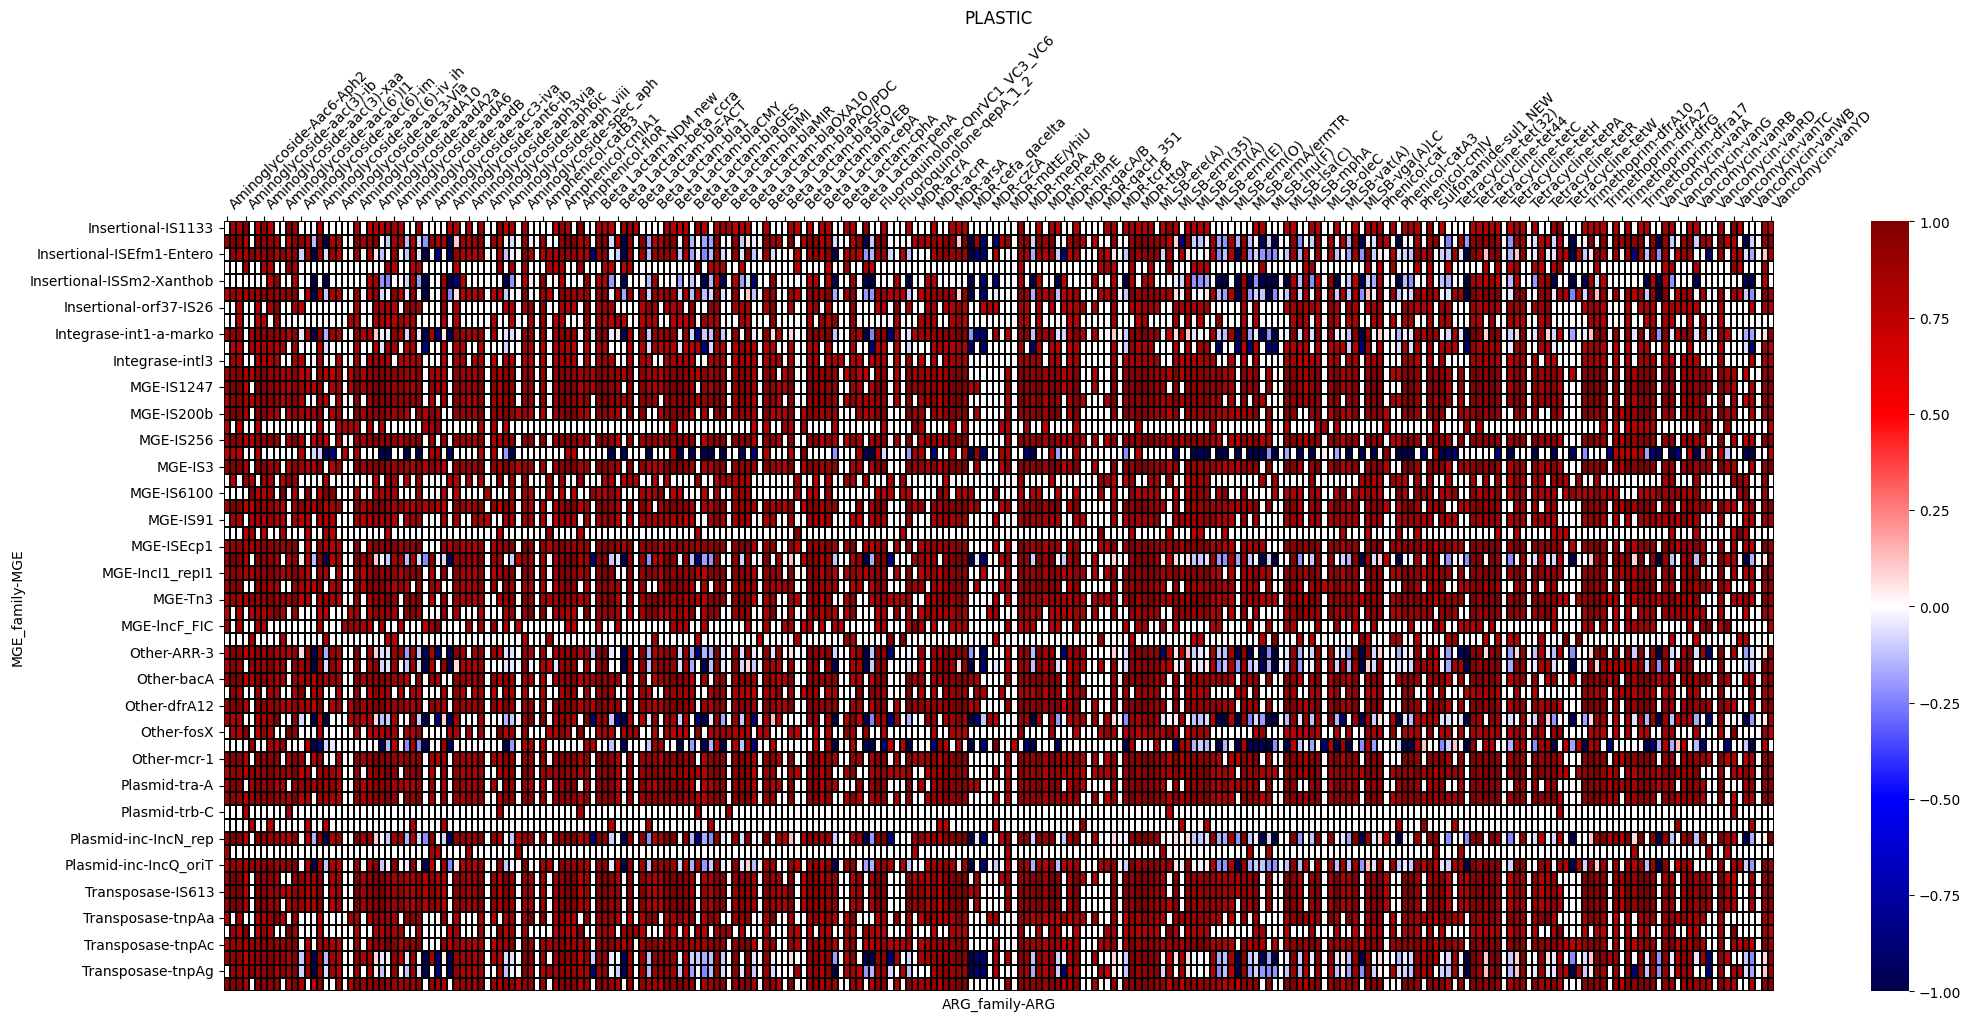

In [18]:
general_compared = abs(general_plastic) - abs(general_control)
general_compared = general_compared.fillna(0)

fig, ax = plt.subplots(figsize=(25,10))
red_cmap = mpl.colormaps["seismic"]
#red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(general_compared.T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003)#, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("PLASTIC")
ax.xaxis.tick_top()

## EN ARDLEY SÓLO
Como el título indica, misma idea, sólo en Ardley

In [16]:
#del general_plastic
#del general_control
del general_compared

In [17]:
corr_data = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "plastic") & (work_data["place"] == "ardley")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "plastic") & (work_data["place"] == "ardley")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "n_log2",
                            threshold = 0.75,
                            p_val = 0.001,
                            min_n_global = 3,
                            min_n_x = 2,
                            min_n_y = 1
                           )
ardley_plastic = dict_pivotizer(corr_data, copy = False,
                               id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                               id1_fam = "MGE_family", id2_fam = "ARG_family")
ardley_plastic = ardley_plastic.fillna(0)
#ardley_plastic

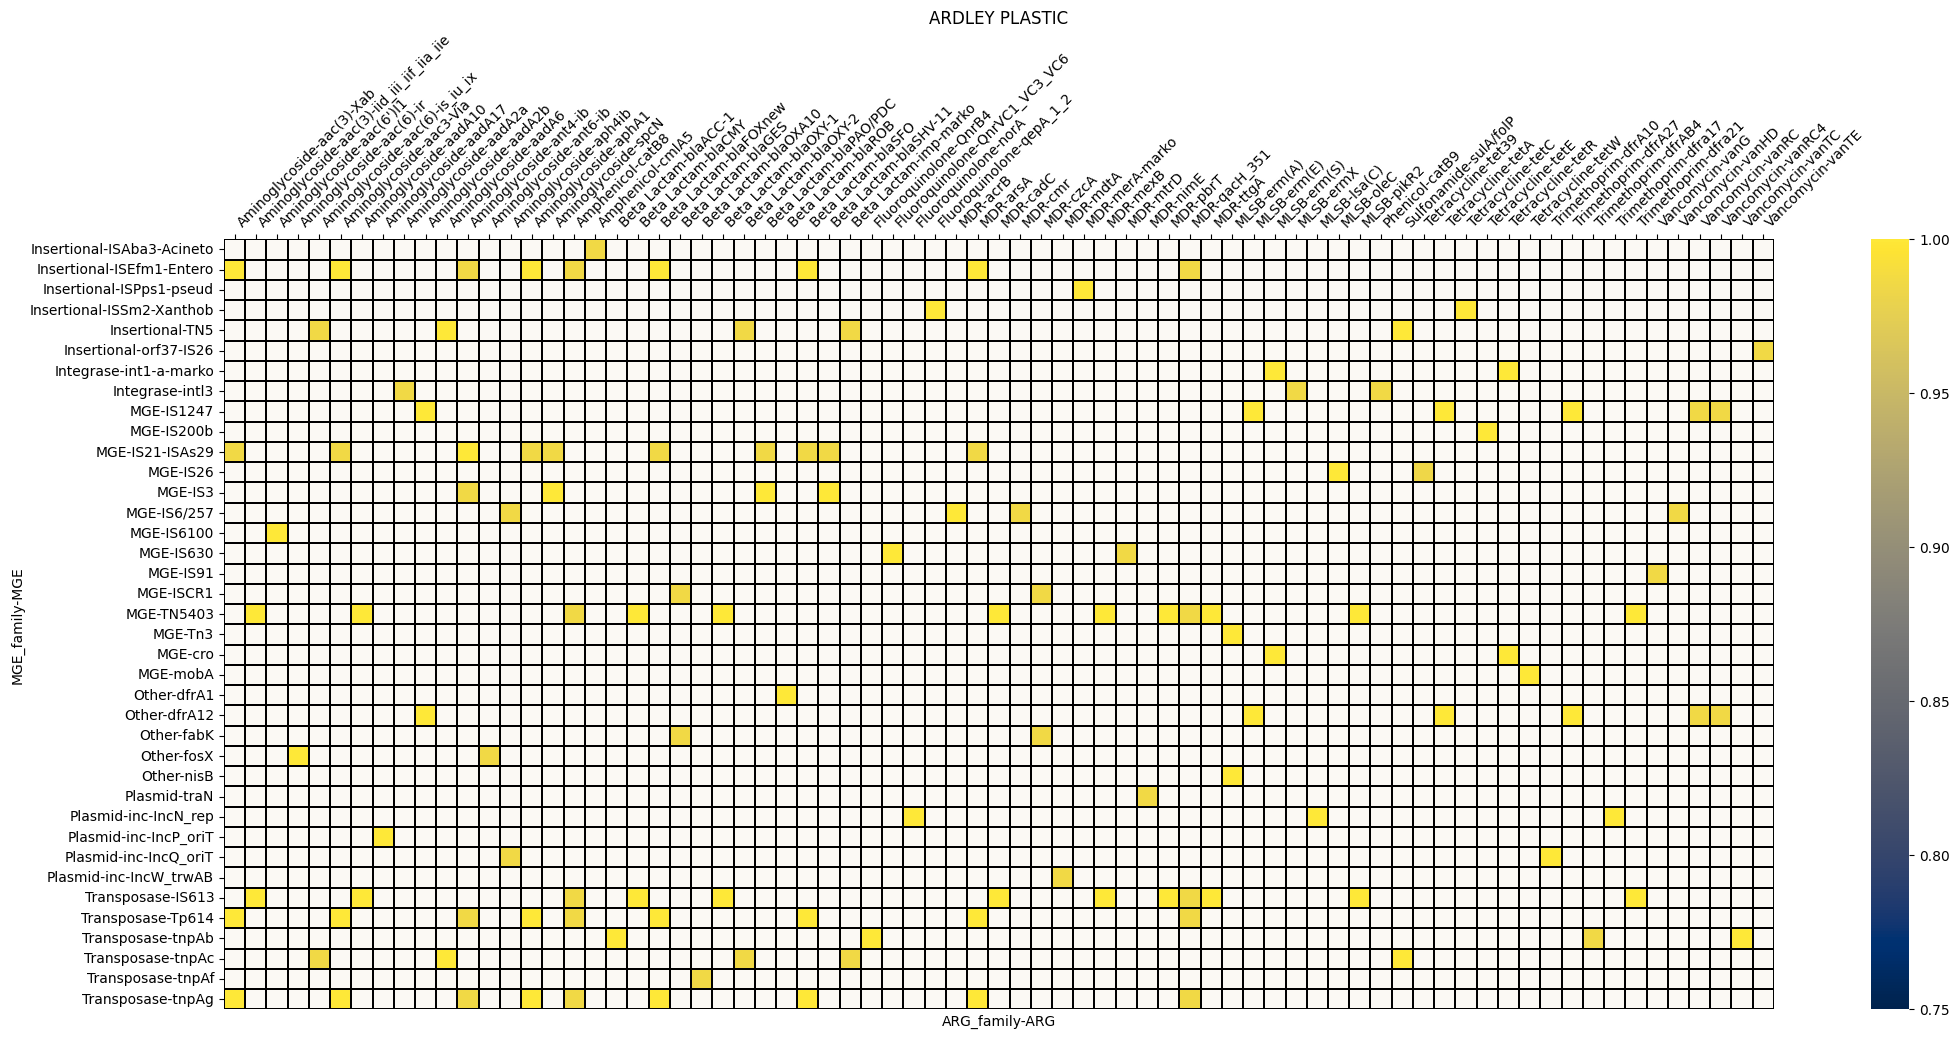

In [18]:
fig, ax = plt.subplots(figsize=(25,10))
red_cmap = mpl.colormaps["cividis"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(abs(ardley_plastic.T), 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.75,
                   linecolor = "black",
                   linewidths = 0.003, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("ARDLEY PLASTIC")
ax.xaxis.tick_top()

In [19]:
#generar el esqueleto a usar
empty_pivot = ardley_plastic.copy(deep = True)

for col in empty_pivot.columns:
    empty_pivot[col].values[:] = 0
#empty_pivot.tail()

In [20]:
corr_data = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "control") & (work_data["place"] == "ardley")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "control") & (work_data["place"] == "ardley")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "n_log2",
                            threshold = 0.75,
                            p_val = 0.001,
                            min_n_global = 3,
                            min_n_x = 2,
                            min_n_y = 1
                           )
ardley_control = dict_pivotizer(corr_data, copy = False,
                               id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                               id1_fam = "MGE_family", id2_fam = "ARG_family")
ardley_control = empty_pivot + ardley_control
ardley_control = ardley_control.fillna(0)

ValueError: Length of new names must be 1, got 2

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
red_cmap = mpl.colormaps["cividis"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(abs(ardley_control.T), 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.9,
                   linecolor = "black",
                   linewidths = 0.003, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("ARDLEY SURROUNDING ENVIRONMENT")
ax.xaxis.tick_top()

In [ ]:
ardley_compared = abs(ardley_plastic) - abs(ardley_control)
ardley_compared = ardley_compared.fillna(0)

fig, ax = plt.subplots(figsize=(25,10))
red_cmap = mpl.colormaps["coolwarm"]
#red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(ardley_compared.T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003)#, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("ARDLEY COMPARED")
ax.xaxis.tick_top()

## EN LAGOS SÓLO

In [ ]:
del ardley_plastic
del ardley_control
del ardley_compared

In [ ]:
corr_data = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "plastic") & (work_data["place"] != "ardley")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "plastic") & (work_data["place"] != "ardley")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "n_log2",
                            threshold = 0.0,
                            p_val = 0.01,
                            min_n_global = 3,
                            min_n_x = 2,
                            min_n_y = 1
                           )
lake_plastic = dict_pivotizer(corr_data, copy = False,
                               id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                               id1_fam = "MGE_family", id2_fam = "ARG_family")
lake_plastic = lake_plastic.fillna(0)
#lake_plastic

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
red_cmap = mpl.colormaps["cividis"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(abs(lake_plastic.T), 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.75,
                   linecolor = "black",
                   linewidths = 0.003, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("LAKES PLASTIC")
ax.xaxis.tick_top()

In [ ]:
#generar el esqueleto a usar
empty_pivot_small = lake_plastic.copy(deep = True)

for col in empty_pivot_small.columns:
    empty_pivot_small[col].values[:] = 0

In [ ]:
corr_data = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "control") & (work_data["place"] != "ardley")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "control") & (work_data["place"] != "ardley")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "n_log2",
                            threshold = 0.0,
                            p_val = 0.001,
                            min_n_global = 3,
                            min_n_x = 2,
                            min_n_y = 1
                           )
lake_control = dict_pivotizer(corr_data, copy = False,
                               id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                               id1_fam = "MGE_family", id2_fam = "ARG_family")
lake_control = empty_pivot_small + lake_control
lake_control = lake_control.fillna(0)

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
red_cmap = mpl.colormaps["cividis"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(abs(lake_control.T), 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.75,
                   linecolor = "black",
                   linewidths = 0.003, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("LAKES CONTROL")
ax.xaxis.tick_top()

In [ ]:
lake_compared = abs(lake_plastic) - abs(lake_control)
lake_compared = lake_compared.fillna(0)

fig, ax = plt.subplots(figsize=(25,10))
red_cmap = mpl.colormaps["coolwarm"]
#red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(lake_compared.T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003)#, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("LAKE COMPARED")
ax.xaxis.tick_top()

# ESTUDIO DE LA CORRELACIÓN GLOBAL DESGLOSADA POR FAMILIAS DE AB
Como el propio título indica, gráficos como el de los globales, pero separados por familias de Ab, para que ocupen lo que tengan que ocupar pero se pueda distinguir el gen individual

In [19]:
del lake_plastic
del lake_control
del lake_compared

NameError: name 'lake_plastic' is not defined

In [20]:
# Bloque gigantesco de declarar nuevos sub dfs con los que ir trabajando 
gp_aminoglycoside = general_plastic.T["Aminoglycoside"]
gp_bl = general_plastic.T["Beta Lactam"]
gp_fluoroquinolone = general_plastic.T["Fluoroquinolone"]
gp_mdr = general_plastic.T["MDR"]
gp_mlsb = general_plastic.T["MLSB"]
gp_phenicol = general_plastic.T[["Phenicol", "Amphenicol"]]
gp_sulfonamide = general_plastic.T["Sulfonamide"]
gp_tetracycline = general_plastic.T["Tetracycline"]
gp_trimethoprim = general_plastic.T["Trimethoprim"]
gp_vancomycin = general_plastic.T["Vancomycin"]

gc_aminoglycoside = general_control.T["Aminoglycoside"]
gc_bl = general_control.T["Beta Lactam"]
gc_fluoroquinolone = general_control.T["Fluoroquinolone"]
gc_mdr = general_control.T["MDR"]
gc_mlsb = general_control.T["MLSB"]
gc_phenicol = general_control.T[["Phenicol", "Amphenicol"]]
gc_sulfonamide = general_control.T["Sulfonamide"]
gc_tetracycline = general_control.T["Tetracycline"]
gc_trimethoprim = general_control.T["Trimethoprim"]
gc_vancomycin = general_control.T["Vancomycin"]

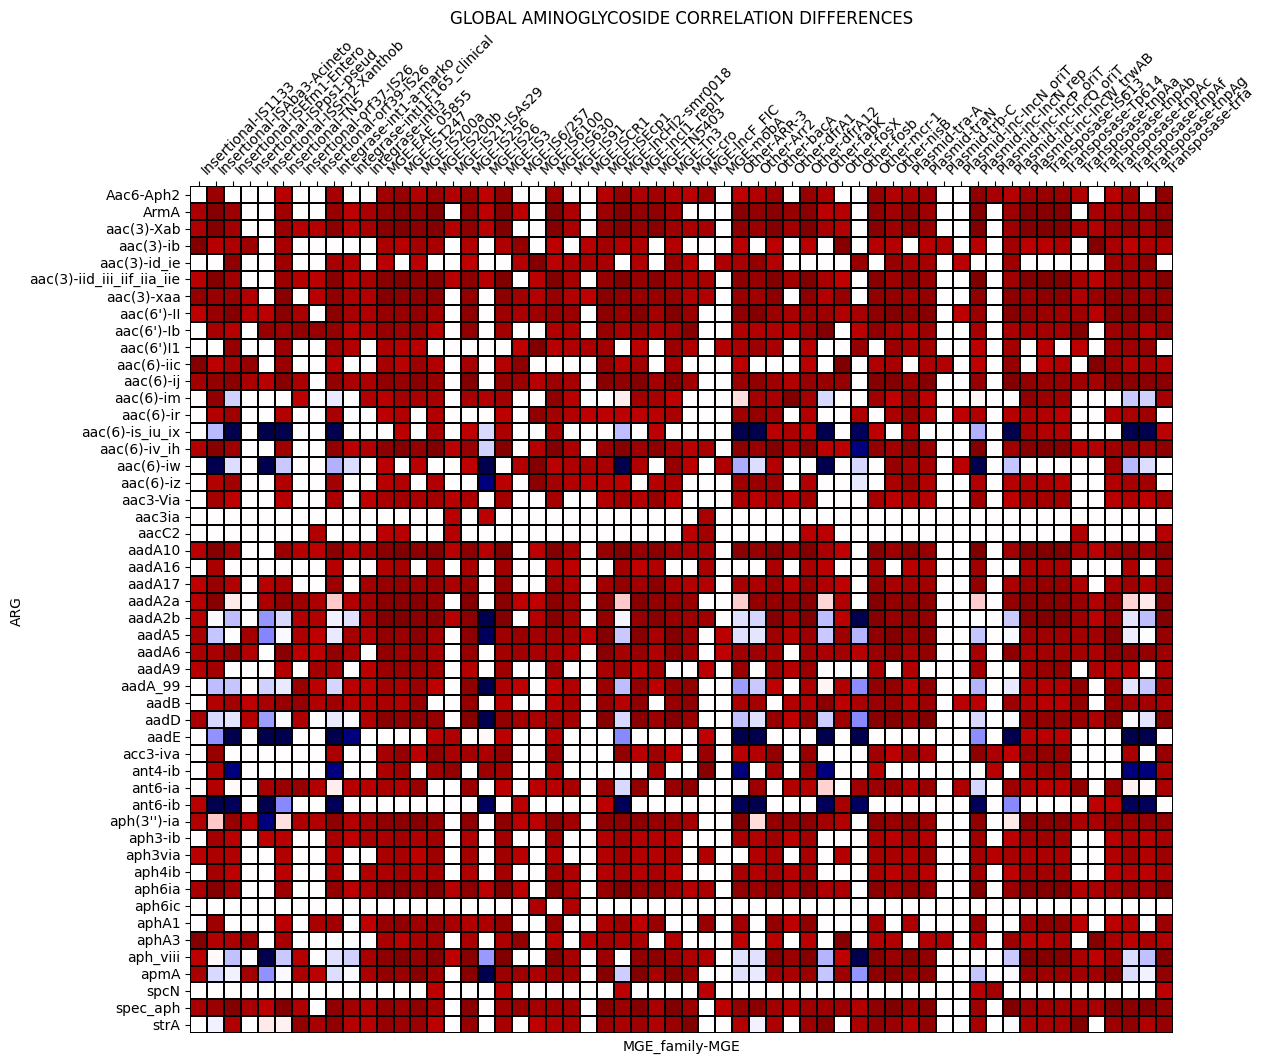

In [21]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_aminoglycoside - gc_aminoglycoside).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL AMINOGLYCOSIDE CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

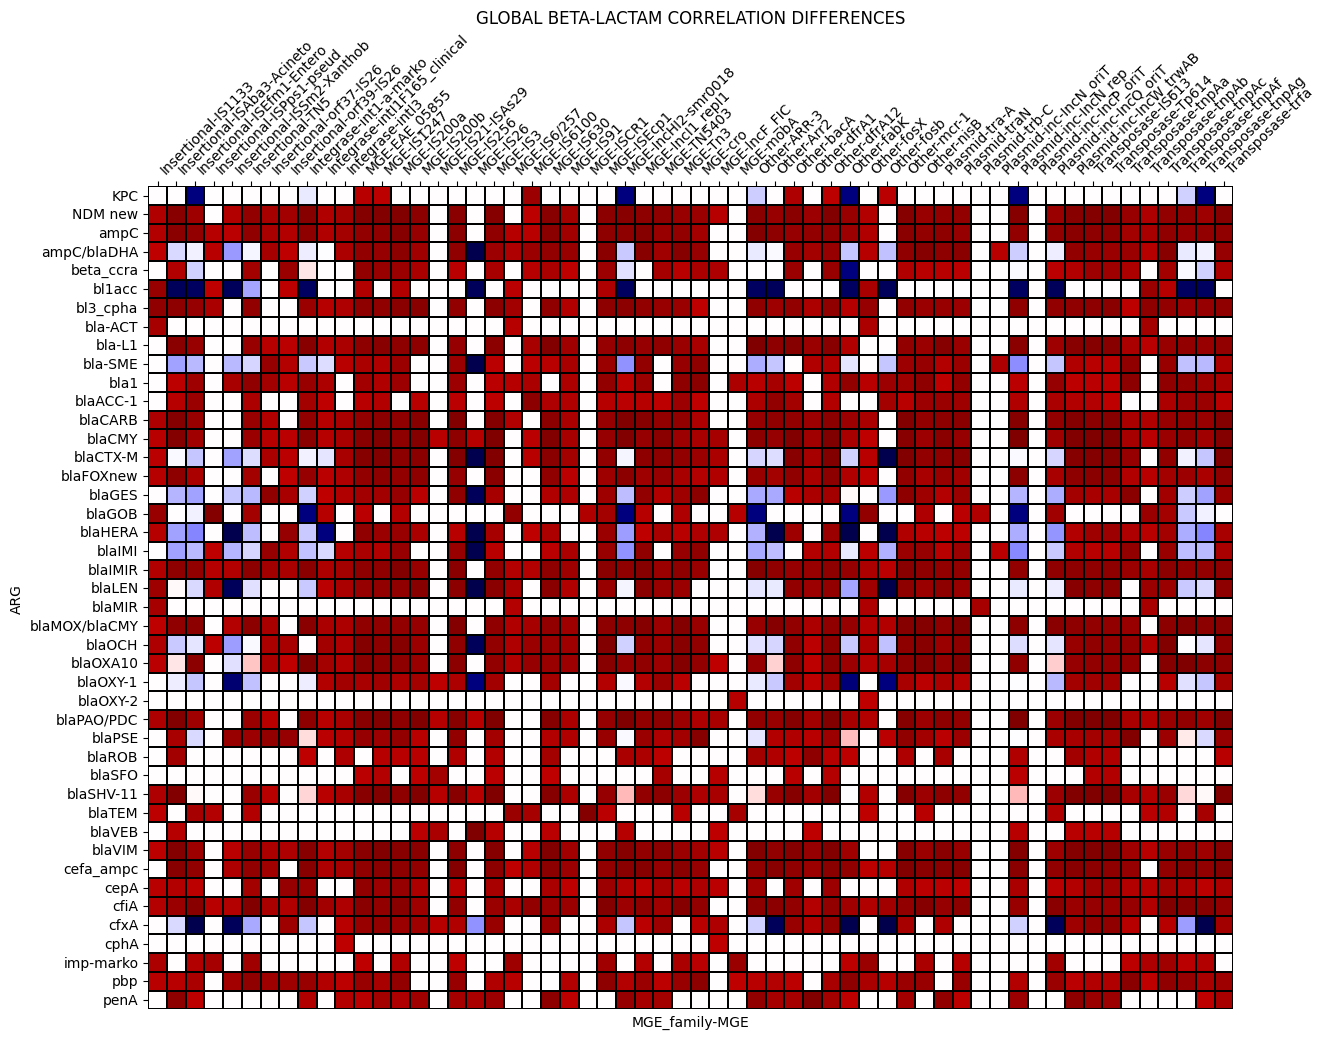

In [22]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_bl - gc_bl).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL BETA-LACTAM CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

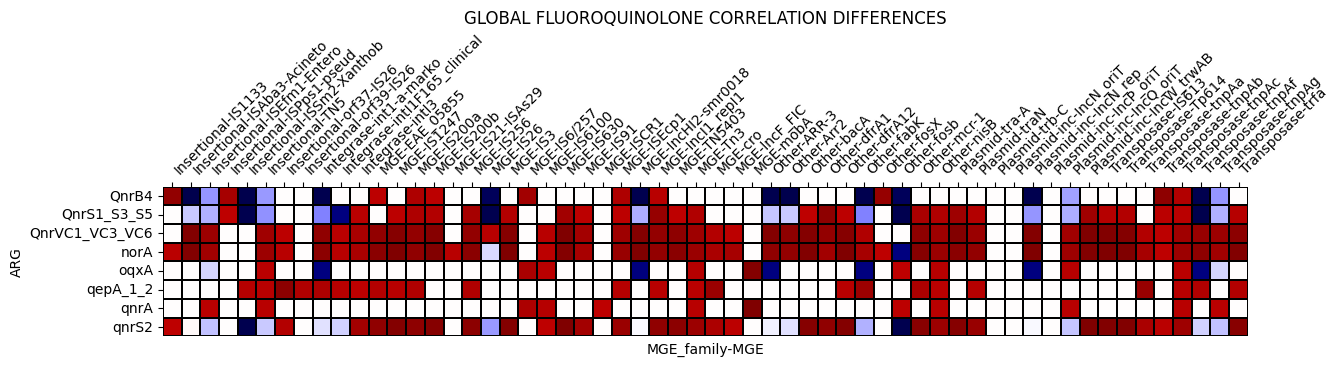

In [23]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_fluoroquinolone - gc_fluoroquinolone).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL FLUOROQUINOLONE CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

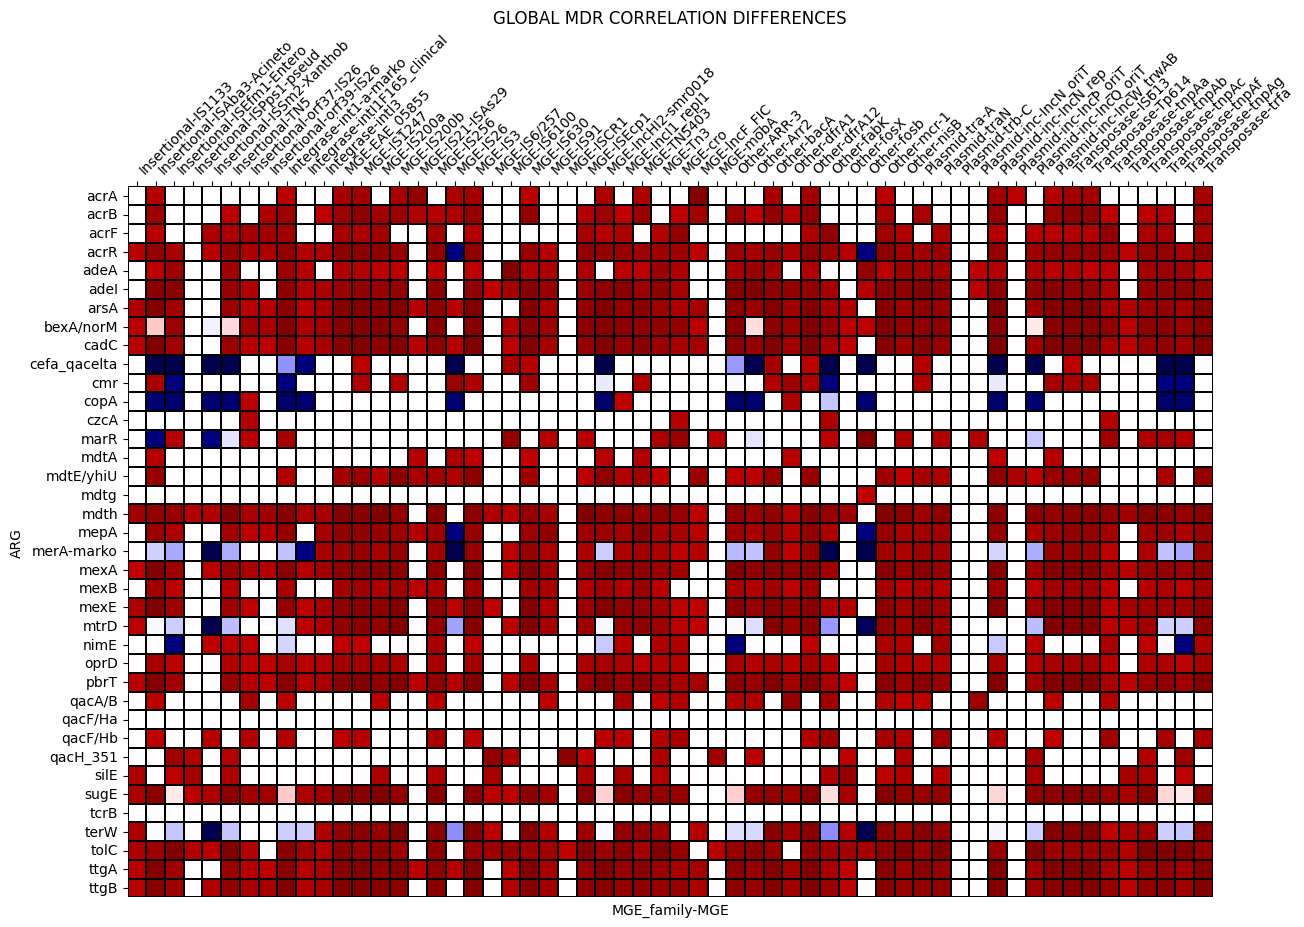

In [24]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_mdr - gc_mdr).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL MDR CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

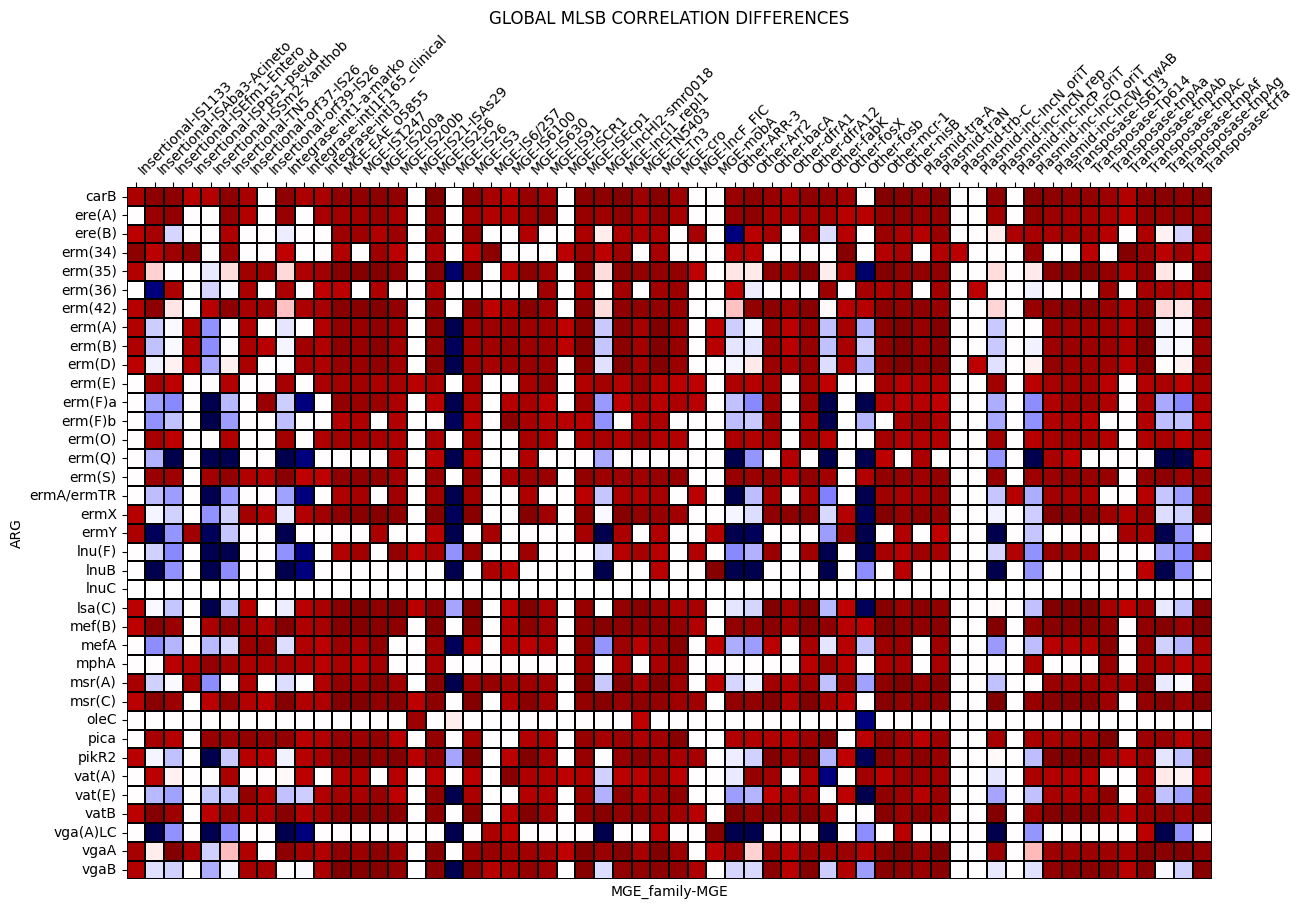

In [25]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_mlsb - gc_mlsb).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL MLSB CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

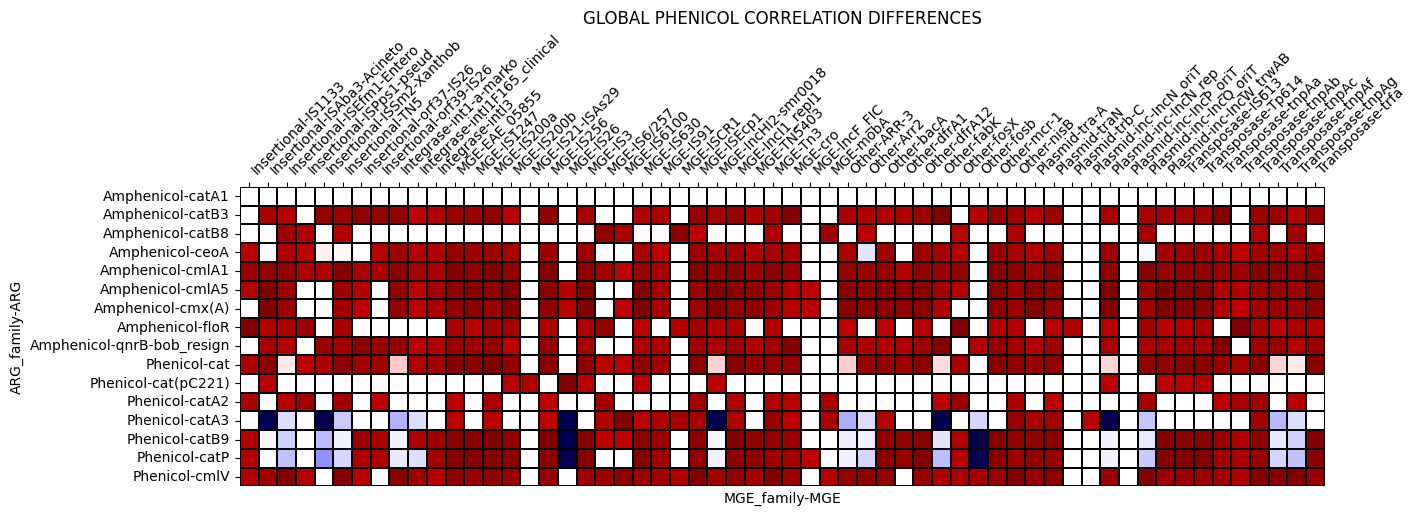

In [26]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_phenicol - gc_phenicol).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL PHENICOL CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

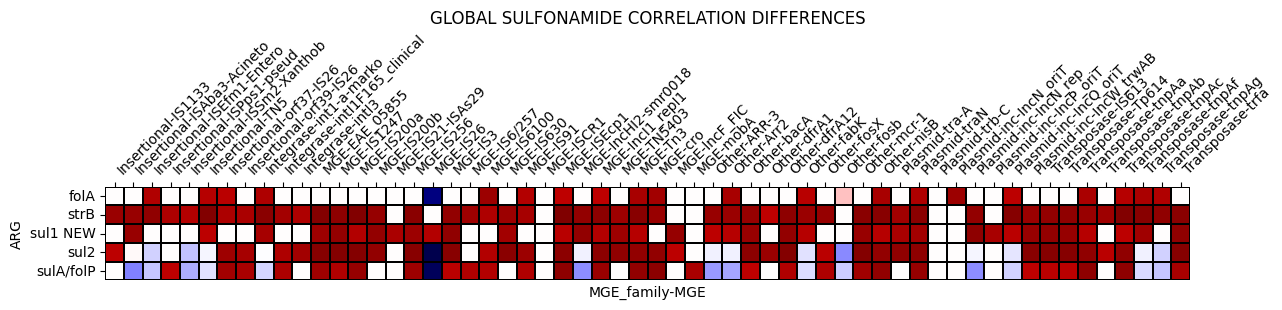

In [27]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_sulfonamide - gc_sulfonamide).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL SULFONAMIDE CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

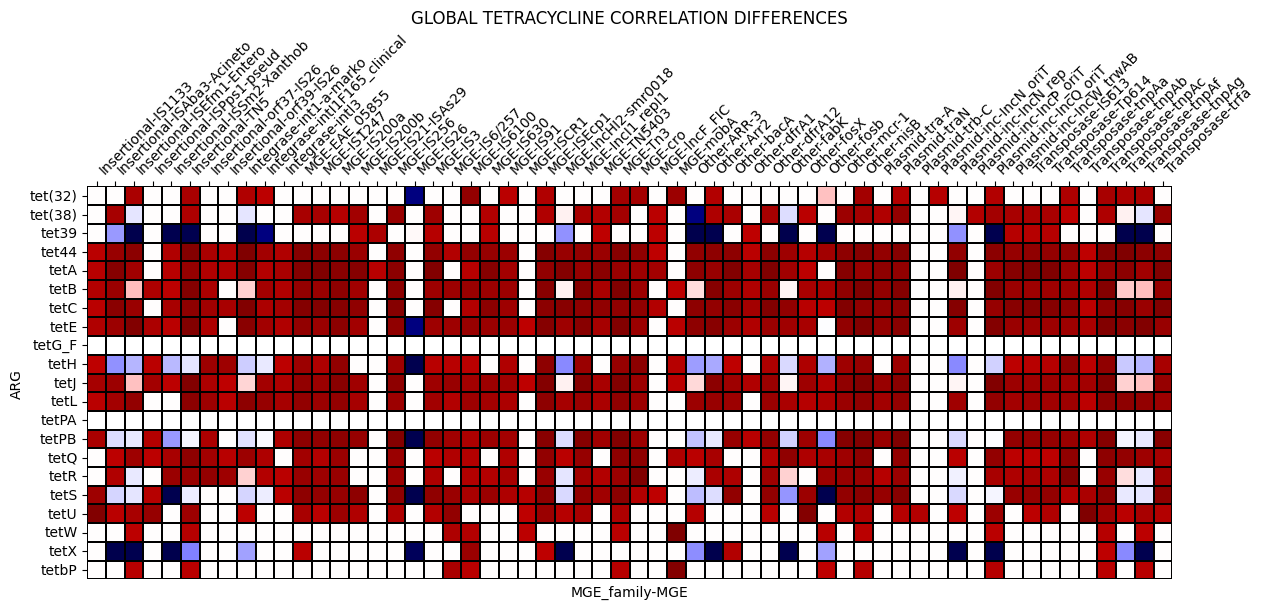

In [28]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_tetracycline - gc_tetracycline).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL TETRACYCLINE CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

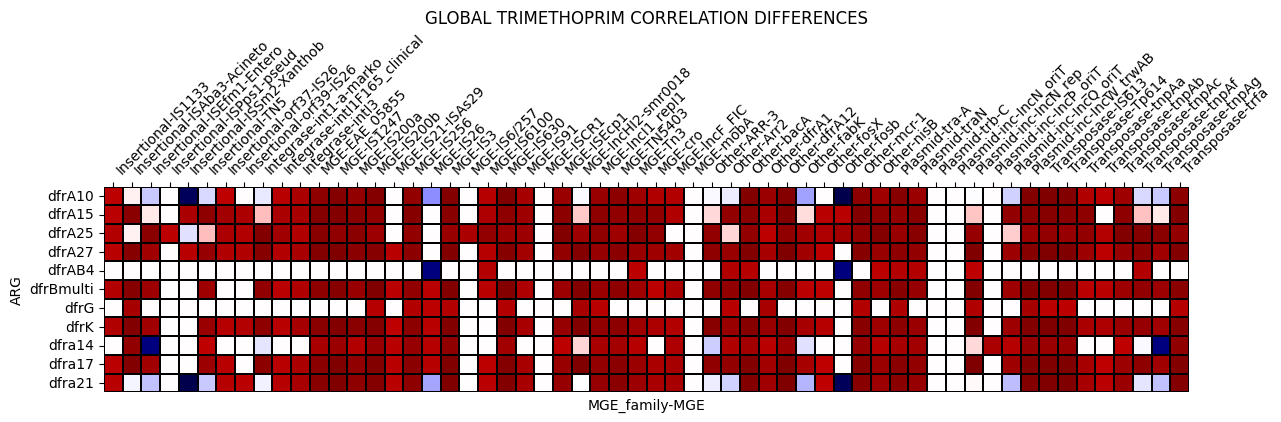

In [29]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_trimethoprim - gc_trimethoprim).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL TRIMETHOPRIM CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

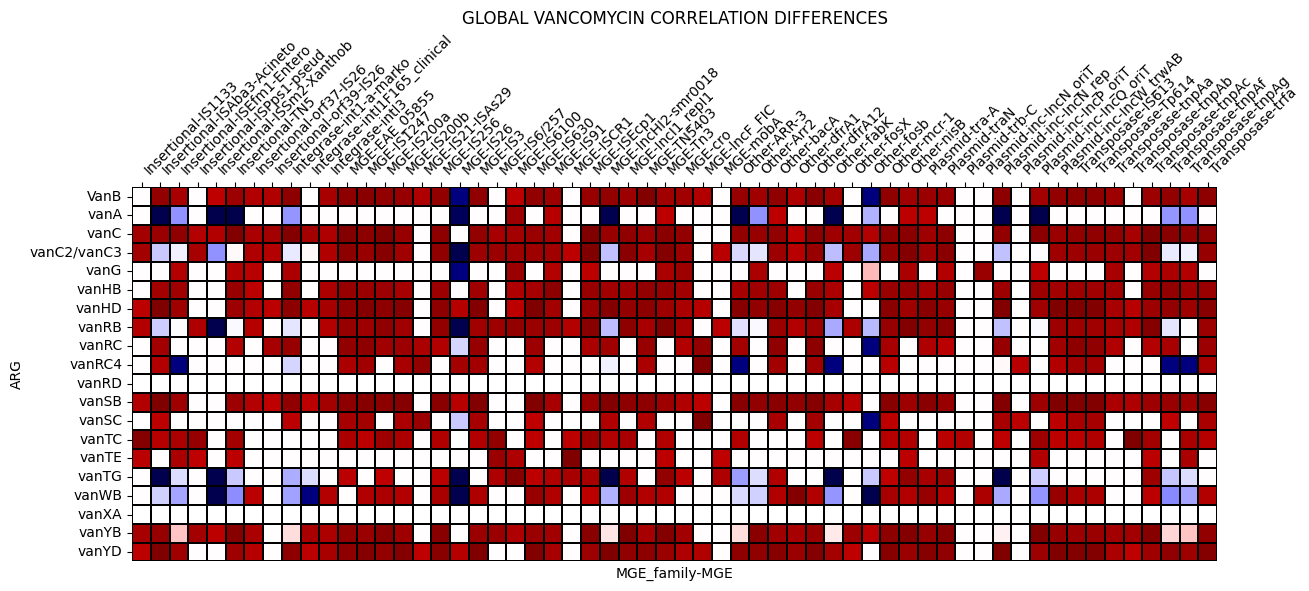

In [30]:
fig, ax = plt.subplots(figsize=(14,11))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("#fbf9f4") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap((gp_vancomycin - gc_vancomycin).T, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.003, robust = True, square = True, cbar = False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("GLOBAL VANCOMYCIN CORRELATION DIFFERENCES")
ax.xaxis.tick_top()

# PROPORCIONES Y ESTADÍSTICOS QUE DAR EN EL PAPER


In [31]:
strong_plastic  = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "plastic")],
                                  y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "plastic")],
                                  merge_col_name = "sample",
                                  groupby_name = "Assay",
                                  test_col = "n_log2",
                                  threshold = 0.9,
                                  p_val = 0.001,
                                  min_n_global = 4,
                                  min_n_x = 2,
                                  min_n_y = 2
                                 )

In [33]:
strong_control  = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "control")],
                                  y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "control")],
                                  merge_col_name = "sample",
                                  groupby_name = "Assay",
                                  test_col = "n_log2",
                                  threshold = 0.9,
                                  p_val = 0.001,
                                  min_n_global = 4,
                                  min_n_x = 2,
                                  min_n_y = 2
                                 )

/home/juanma/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [23]:
print(len(strong_plastic))
print(len(strong_control))
#print(list(strong_plastic)[:])
#print(type(strong_plastic))
#strong_plastic

3380
1015


In [34]:
strong_shared = set(strong_plastic) & set(strong_control)
print(len(strong_shared))

strong_control = set(strong_control) - set(strong_plastic)
print(len(strong_control))

strong_plastic = set(strong_plastic) - set(strong_control)
print(len(strong_plastic))

280
735
3380


Ahora querría generar un archivo en el que se guarde un diccionario de diccionarios, con llaves nombre de tipología (plástico, control, compartido), valores diccionarios de llave nombre de MGE, valor lista de sus ARG asociados. No estoy tan interesado en los estadísticos en sí, asi que por ahora no los meto (pero podría a base de que el valor sea una lista de listas con ARG, valor del estadístico y p valor)

In [35]:
def pair_set_dictionizer(set_name):
    """
    Take a set with the shape (thingy_1, thingy_2) and spit back a dictionary of that same information but cleaner, such as {"thingy_1": thingy_2a, thingy_2b, thingy_2f}, etc
    """
    thingy1_lst = list()
    for entry in set_name:
        current_thingy1 = list(entry)[0]
        if current_thingy1 not in thingy1_lst: thingy1_lst.append(current_thingy1)
    result_dict = dict()
    for thingy1 in thingy1_lst:
        for entry in set_name:
            current_things = list(entry)
            if thingy1 == current_things[0]:
                if thingy1 not in result_dict.keys():
                    result_dict[thingy1] = []
                    result_dict[thingy1].append(current_things[1])
                    continue
                else:
                    result_dict[thingy1].append(current_things[1])
    return result_dict

In [36]:
strong_plastic_dict = pair_set_dictionizer(strong_plastic)
strong_control_dict = pair_set_dictionizer(strong_control)
strong_shared_dict = pair_set_dictionizer(strong_shared)

all_info = {}
all_info["plastic_ex_corrs"] = strong_plastic_dict
all_info["control_ex_corrs"] = strong_control_dict
all_info["shared_corrs"] = strong_shared_dict


In [37]:
import json

with open("../data/resistome_data/metadata/correlations_per_typology.json", "w") as fp:
    json.dump(all_info, fp)

/home/juanma/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juanma/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='MGE', ylabel='ARG'>

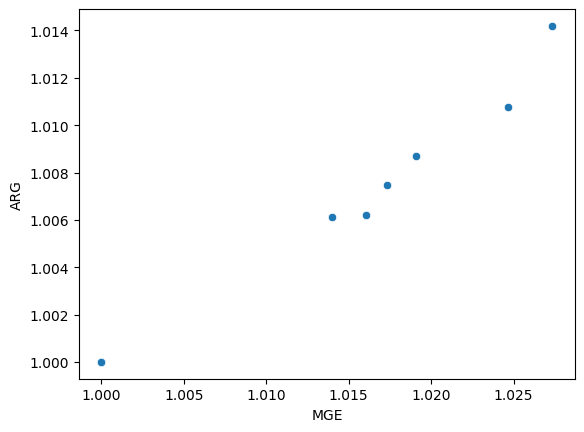

In [38]:
#'IS3', 'blaPAO/PDC
data_1 = work_data.loc[(work_data["Assay"] == "IS3") & (work_data["type_g"] == "plastic")]
data_2 = work_data.loc[(work_data["Assay"] == "blaPAO/PDC") & (work_data["type_g"] == "plastic")]
f_data = pd.merge(data_1, data_2, on = "sample")

f_data = f_data.rename(columns = {"rel_ab_x": "MGE", "rel_ab_y": "ARG"})
f_data = f_data[["sample", "MGE", "ARG"]]

sns.scatterplot(data=f_data, x="MGE", y="ARG")